<a href="https://colab.research.google.com/github/AndresChauca/Drone-Proyect-Saturdays-AI/blob/master/Drone_Proyect_Saturdays_AI_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Distanciamiento de Personas**
## *Drone Proyect Saturdays AI* 

>![alt text](https://raw.githubusercontent.com/AndresChauca/Drone-Proyect-Saturdays-AI/master/logoai6uio.png)



Este algoritmo se enfoca en la deteccion de personas a traves de un sistema de detección de objetos en tiempo real llamado YOLOv3 y a la vez realiza una verificacion del distanciamiento entre ellas. El algoritmo queda dividio en la siguientes secciones:


-   Con [YOLOv3](https://pjreddie.com/darknet/yolo/) podemos detectar objetos a una velocidad relativamente alta. Con una GPU podríamos procesar más de 45 cuadros/segundo mientras que con una CPU alrededor de un cuadro por segundo 


## Habilitar la GPU

Primero, deberá habilitar las GPU para el portátil:

- Navegue a Editar → Configuración del cuaderno
- seleccione GPU del menú desplegable Acelerador de hardware


## Imports

In [0]:
import cv2
import urllib.request
import numpy as np
from matplotlib import pyplot as plt
cv2.__version__

'4.1.2'

## Enviroment setup

In [0]:
# This is needed to display the images.
%matplotlib inline

## Cargando yolov3
Para ejecutar el algoritmo necesitamos tres archivos:

**Archivo de peso:** es el modelo entrenado, el núcleo del algoritmo para detectar los objetos.

**Archivo Cfg :** es el archivo de configuración, donde hay todas las configuraciones del algoritmo.

**Archivos de nombre:** contiene el nombre de los objetos que el algoritmo puede detectar.

In [0]:
# Descargar yolov3.weights en una carpeta temporal
!wget --no-check-certificate \
    https://pjreddie.com/media/files/yolov3.weights \
    -O /tmp/yolov3.weights

# Descargar yolov3.cfg en una carpeta temporal
!wget --no-check-certificate \
    https://raw.githubusercontent.com/ultralytics/yolov3/master/cfg/yolov3.cfg \
    -O /tmp/yolov3.cfg

# Descargar coco.names en una carpeta temporal
!wget --no-check-certificate \
    https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names \
    -O /tmp/coco.names

net = cv2.dnn.readNetFromDarknet("/tmp/yolov3.cfg","/tmp/yolov3.weights")
classes = []
with open("/tmp/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

--2020-05-03 02:08:16--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/tmp/yolov3.weights’

/tmp/yolov3.weights 100%[===================>] 236.52M  4.09MB/s    in 55s     

2020-05-03 02:09:11 (4.27 MB/s) - ‘/tmp/yolov3.weights’ saved [248007048/248007048]

--2020-05-03 02:09:12--  https://raw.githubusercontent.com/ultralytics/yolov3/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8338 (8.1K) [text/plain]
Saving to: ‘/tmp/yolov3.cfg’

/tmp/yolov3.cfg     100%[===================>]   8.14K  --.-KB/s    

## Cargando imagen
Luego cargamos la imagen donde queremos realizar la detección de objetos y también obtenemos su ancho y alto.

--2020-05-03 04:07:26--  https://media.istockphoto.com/photos/top-view-people-walking-white-floor-or-large-crowd-of-anonymous-picture-id1178084326
Resolving media.istockphoto.com (media.istockphoto.com)... 52.85.109.33, 52.85.109.124, 52.85.109.67, ...
Connecting to media.istockphoto.com (media.istockphoto.com)|52.85.109.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276760 (270K) [image/jpeg]
Saving to: ‘/tmp/personas.jpg’

/tmp/personas.jpg   100%[===================>] 270.27K  --.-KB/s    in 0.1s    

2020-05-03 04:07:26 (2.32 MB/s) - ‘/tmp/personas.jpg’ saved [276760/276760]



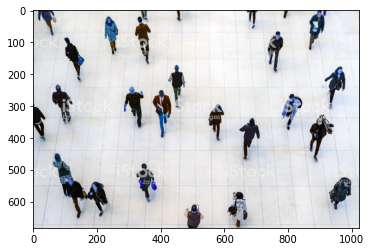

In [0]:
# URLs de imagenes
# https://c8.alamy.com/compes/mb6awd/desde-arriba-gente-de-negocios-y-el-saludo-de-enlace-se-reunio-en-el-concurrido-hall-de-la-organizacion-mb6awd.jpg
# https://media.istockphoto.com/photos/top-view-people-walking-white-floor-or-large-crowd-of-anonymous-picture-id1178084326 
# https://c8.alamy.com/compes/fj415m/la-gente-en-la-plaza-los-peatones-caminar-visto-desde-arriba-de-alta-vista-fj415m.jpg
# https://thumbs.dreamstime.com/z/gente-que-camina-y-toma-las-fotos-en-un-cuadrado-grande-129222318.jpg

# Leer una imagen descargada en un repositorio temporal
!wget --no-check-certificate \
    https://media.istockphoto.com/photos/top-view-people-walking-white-floor-or-large-crowd-of-anonymous-picture-id1178084326  \
    -O /tmp/personas.jpg

img = cv2.imread("/tmp/personas.jpg")

img = cv2.resize(img, None, fx=1, fy=1)
height, width, channels = img.shape

plt.imshow(img)

## Detectando objetos
Aplicamos una única red neuronal a la imagen completa. Esta red divide la imagen en regiones y predice cuadros delimitadores y probabilidades para cada región. Estos cuadros delimitadores están ponderados por las probabilidades predichas.

Ahora pasamos la imagen a la red para hacer la detección, pero antes necesitamos para convertirla en blob, este se utiliza para extraer características de la imagen y cambiar su tamaño. YOLO acepta tres tamaños:

**320 × 320** es pequeño, así que menos precisión pero mejor velocidad

**416 × 416** está en el medio y obtienes un poco de ambos.

**608 × 608** es más grande, así que alta precisión y velocidad lenta


In [0]:
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

Las salidas son el resultado de la detección. outs es una matriz que contiene toda la información sobre los objetos detectados, su posición y la confianza en la detección.

## Obtencion las cordenadas de los rectangulos (boxes) de cada detección
Recorremos el conjunto de salidas, calculamos la confianza y elegimos un umbral de confianza, establecido en 0,5; si es mayor, consideramos que el objeto se detectó correctamente; de ​​lo contrario, lo omitimos.

El umbral va de 0 a 1. Cuanto más cercano a 1, mayor es la precisión de la detección, mientras que cuanto más cercano a 0, menor es la precisión, pero también es mayor el número de objetos detectados.

In [0]:
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:

            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

Cuando realizamos la detección, sucede que tenemos más cuadros para el mismo objeto, por lo que deberíamos usar otra función para eliminar este "ruido".
Se llama supresión no máxima.

In [0]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

## Mostrando información en la pantalla
Finalmente extraemos toda la información y la mostramos en la pantalla.

Cuadro : contiene las coordenadas del rectángulo alrededor del objeto detectado.
Etiqueta : es el nombre del objeto detectado
Confianza : la confianza sobre la detección de 0 a 1.

box coords:  0   [12, 1, 62, 80] labels: person
******************************
box coords:  1   [223, 12, 40, 125] labels: person
******************************
box coords:  2   [858, -1, 59, 126] labels: person
******************************
box coords:  3   [320, 22, 51, 134] labels: person
******************************
box coords:  4   [735, 64, 48, 124] labels: person
******************************
box coords:  5   [97, 86, 60, 131] labels: person
******************************
box coords:  6   [422, 176, 50, 127] labels: person
******************************
box coords:  7   [915, 177, 56, 126] labels: person
******************************
box coords:  8   [61, 239, 61, 107] labels: person
******************************
box coords:  9   [285, 241, 66, 129] labels: person
******************************
box coords:  10   [376, 250, 51, 145] labels: person
******************************
box coords:  11   [778, 265, 57, 107] labels: person
******************************
box coords:  

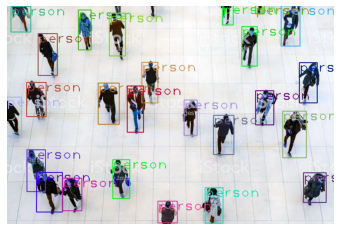

In [0]:

font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
      # El siguiente if es para que detecte solo personas, la clases persona tiene el class_id = o
      if class_ids[i] == 0: # comentar esta linea si desea detectar cualquier objeto 
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        print("box coords: ", i, " ", boxes[i], "labels:", label)
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 2)
        print('*' * 30)


plt.imshow(img)
plt.axis('Off')
plt.show()